In [1]:
# Video enhanced classification V2
# does away with first classification to find areas of detection
# assumes videographer places objects of interest in the visual center of attention

# Produce images from field video (example used here: banana and cacao plants with fruits)
# Use variations in luminance to generate varied images with constant content
# Use photgraphic intent (center of attention) to help prune spurious results

# Pass tthe images from the video to a bank of 'imperfectly' pretrained classifiers (they tend to only find one type of plant)
# Collect the varied results
# Combine results to get most likely set of multiple plants
# Option: use audio from video to confirm (See Catch&Release on GitHub: https://github.com/realtechsupport/c-plus-r)
# March 2020, RTS
#----------------------------------------------------------------------------------------------
import argparse
import glob
import multiprocessing as mp
import os, sys
import time
import cv2
import tqdm
import json
import numpy
from  matplotlib import pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.checkpoint import DetectionCheckpointer

In [2]:
# add helper file
sys.path.append('/home/rts/code/')
from similarities import *
from av_helper import *
from utilities_v2 import *

#set data paths
datapath = '/home/rts/data/'
savepath = datapath + 'tempimgs/'
path2model = '/home/rts/detectron2/demo/output/'
name = "labelled_94imgs"
jsonpath = '/home/rts/data/labelled_94imgs.json'
imagespath = '/home/rts/data/labelled_94imgs/'

In [3]:
num_classes = 26

from detectron2.data.datasets import register_coco_instances

register_coco_instances(name, {}, jsonpath, imagespath)
bali26_boxl_metadata = MetadataCatalog.get(name)

dataset_dicts = DatasetCatalog.get(name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [4]:
# START the processing
# get the video and collect stats on luminance (or perceived_luminance, or timing)

import numpy

#delete the images in the tempimg folder
try:
  shutil.rmtree(savepath)
  print('emptying the search directory')
except:
  pass

print('recreating directory: ', savepath)
os.makedirs(savepath)

#set the video  name
videoname = 'banana+cacao.mp4'            
groundtruth = videoname.split('.mp4')[0]

l = get_video_length(datapath+videoname)
print('Length of test video: ', l)

# make images
category = 'blah'
framerate = 3
videopath = datapath + videoname
create_images_from_video(savepath, category, videopath, framerate)

#get luminance stats in a dict, then get max exposed, min exposed, ave exposed
lum_data = []
p_lum_data = []
lums = []

p_lums = []
lum_dict = {}
p_lum_dict = {}

for r, d, f in os.walk(savepath):
    for file in f:
        lum = int(brightness(savepath + file))
        #p_lum = int(perceived_brightness(savepath + file))
        lum_dict = {'imagename' : file, 'luminosity' : lum}
        #p_lum_dict = {'imagename' : file, 'perceived_luminosity' : p_lum}
        lums.append(lum)
        #p_lums.append(p_lum)
        lum_data.append(lum_dict)
        #p_lum_data.append(p_lum_dict)


emptying the search directory
recreating directory:  /home/rts/data/tempimgs/
Length of test video:  00:00:19.48


In [5]:
mean_lum = int(numpy.mean(lums))
max_lum = numpy.max(lums)
min_lum = numpy.min(lums)

max_item = next(item for item in lum_data if item["luminosity"] == max_lum)
min_item = next(item for item in lum_data if item["luminosity"] == min_lum)

try:
    mean_item = next(item for item in lum_data if item["luminosity"] == mean_lum)
except:
    print('fixing rounding..')
    mean_lum = mean_lum-1
    mean_item = next(item for item in lum_data if item["luminosity"] == mean_lum)
    
print('Here are the stats')
print(max_item)
print(min_item)
print(mean_item)

Here are the stats
{'imagename': '0051.jpg', 'luminosity': 118}
{'imagename': '0012.jpg', 'luminosity': 107}
{'imagename': '0042.jpg', 'luminosity': 111}


In [6]:
# Find images with min, max and mean luminance values
# (alternative: image at start, middle and end of video....)
# the classifiers respond differently to them...they also show different 'scenes' 
# as they occur in different parts of the video - but they contain the ++same semantics (aka plant types)++
max_lum_img = (max_item['imagename'])
min_lum_img = (min_item['imagename'])
mean_lum_img = (mean_item['imagename'])

valdataset = [max_lum_img, min_lum_img, mean_lum_img]

print('Max, min and mean luminosity images: ', max_lum_img, min_lum_img, mean_lum_img)
print('Number of examples in this collection: ', len(valdataset))

Max, min and mean luminosity images:  0051.jpg 0012.jpg 0042.jpg
Number of examples in this collection:  3


In [7]:
# get center of attention
portrait = False
landscape = False

for img in (valdataset):
    im = cv2.imread(savepath+img)
    height, width, channels = im.shape
    if(height > width):
        portrait = True
    else:
        landscape = True

if(portrait == True):
    margin = height/4
    print('portrait style')
    mid = int(height/2)
    cut_top = int(mid - margin)
    cut_bottom = int(mid + margin)
    print('Boundaries: ', cut_top, cut_bottom) 

portrait style
Boundaries:  480 1440


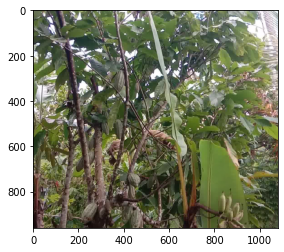

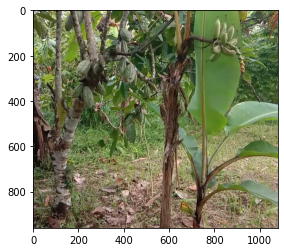

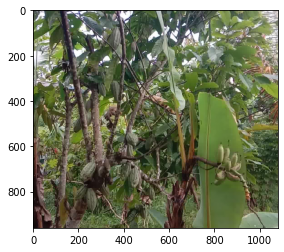

In [8]:
#Check the cropped images
for img in (valdataset):
    im = cv2.imread(savepath+img)
    height, width, channels = im.shape
    
    if(portrait == True):
         crop_img = im[int(cut_top):int(cut_bottom), 0:width]
            
    img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

In [9]:
#list of all the trained models (94 labeled images)
model_list = ['model_faster_rcnn_R_101_C4_3x_labeled_94imgs.pth', 'model_faster_rcnn_R_101_FPN_3x_labeled_94imgs.pth', \
              'model_faster_rcnn_R_50_C4_1x_labeled_94imgs.pth', 'model_faster_rcnn_R_50_FPN_noaug_1x_labeled_94imgs.pth', \
              'model_faster_rcnn_X_101_32x8d_FPN_3x_labeled_94imgs.pth']

In [10]:
# Run the collection of classifiers on the cropped images selected by variation in luminosity
# and sort the final list, leaving out single instances

names = bali26_boxl_metadata.thing_classes
totals = {}

for choice in model_list:
    modelchoice = choice
    modelpath = path2model + modelchoice
    modelzoo_n = modelchoice.split('model_')
    modelzoo_nn = modelzoo_n[1].split('_labeled_94imgs')[0] +'.yaml'
    
    if(choice == 'model_faster_rcnn_R_50_FPN_noaug_1x_labeled_94imgs.pth'):
        prefix = 'Detectron1-Comparisons'
    else:
        prefix = 'COCO-Detection'
    
    modelzoo_choice = os.path.join(prefix, modelzoo_nn)
    
    cfg = get_cfg()
    modelzoo_name = modelzoo_choice
    cfg.merge_from_file(model_zoo.get_config_file(modelzoo_name))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5                                          
    cfg.MODEL.WEIGHTS =  modelpath                                             
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
    cfg.MODEL.ROI_HEADS.NUM_CLASSES =   num_classes                                                     
    predictor = DefaultPredictor(cfg)
    
    combolist = []

    for img in (valdataset):
        im = cv2.imread(savepath+img)
        height, width, channels = im.shape

        if(portrait == True):
             crop_img = im[int(cut_top):int(cut_bottom), 0:width]
        elif(landscape == True):
            crop_img = im[0:height, int(cut_left):int(cut_right)]
        else:
            crop_img = im
            
        img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        #original_image = Image.open(savepath+img, mode='r').convert('RGB')
        outputs = predictor(img_rgb)
        boxes = outputs["instances"].get_fields()["pred_boxes"].tensor.to("cpu").numpy()
        boxes = numpy.around(boxes,decimals=0)
        scores = outputs["instances"].get_fields()["scores"].squeeze().tolist()
        scores = numpy.around(scores,decimals=4)
        predicted_classe_indexes = outputs["instances"].get_fields()["pred_classes"].squeeze().tolist()
        collection = index2name(predicted_classe_indexes, names)

        scores_list = []
        templist = []
    
        if(len(collection) > 0):
            if (len(collection) == 1):
                scores_list.append(scores)
        else:
            scores_list = scores
            
        imgname = img.split('.jpg')[0]
        templist.append(imgname)
        templist.append(collection)
        templist.append(scores)
        combolist.append(templist)

    print('\nGround truth: ', groundtruth)
    print('Classifier: ', modelzoo_choice)
    print('Confidence threshold: ', cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
    print('Results: ', combolist) 
    
        
    #------------------------------------ --------------------------
    # collect the evidence; use instances above threshold to 'vote'
    #---------------------------------------------------------------
    
    hits = []
    unique_hits = []
    
    for probs in combolist:
        for item in probs[1]:
            hits.append(item)
            
    if(not hits):
        pass
    else:
        unique_hits = unique(hits)

    for uni in unique_hits:
        n = hits.count(uni)
        print(uni, n)
        k = totals.get(uni)
        if(k):
            nn = int(k)+n
        else:
            nn = n
        totals.update({uni:nn})


/home/rts/detectron2/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()



Ground truth:  banana+cacao
Classifier:  COCO-Detection/faster_rcnn_R_101_C4_3x.yaml
Confidence threshold:  0.5
Results:  [['0051', ['sugarpalm'], 0.5542], ['0012', ['sugarpalm'], 0.5519], ['0042', [], array([], dtype=float64)]]
sugarpalm 2

Ground truth:  banana+cacao
Classifier:  COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml
Confidence threshold:  0.5
Results:  [['0051', ['cacao'], 0.5086], ['0012', ['taro'], 0.5964], ['0042', ['banana', 'cacao'], array([0.7235, 0.5614])]]
cacao 2
taro 1
banana 1

Ground truth:  banana+cacao
Classifier:  COCO-Detection/faster_rcnn_R_50_C4_1x.yaml
Confidence threshold:  0.5
Results:  [['0051', [], array([], dtype=float64)], ['0012', [], array([], dtype=float64)], ['0042', ['banana'], 0.768]]
banana 1

Ground truth:  banana+cacao
Classifier:  Detectron1-Comparisons/faster_rcnn_R_50_FPN_noaug_1x.yaml
Confidence threshold:  0.5
Results:  [['0051', ['sugarpalm'], 0.5867], ['0012', ['sugarpalm'], 0.6971], ['0042', [], array([], dtype=float64)]]
sugarpalm 2

In [11]:
#-------------------------------------------------------------------
# final tally
#-------------------------------------------------------------------

total = []
for plant, occurance in totals.items():  
    if occurance > 1:
        total.append(plant)

print('\nFINAL TALLY: ', totals)
print(' > FINAL TALLY above single instance ', total)



FINAL TALLY:  {'sugarpalm': 6, 'cacao': 4, 'taro': 1, 'banana': 3, 'bamboo': 1, 'dragonfruit': 1}
 > FINAL TALLY above single instance  ['sugarpalm', 'cacao', 'banana']
